# **Rastgele Orman (Random Forest) Yöntemi ile Arazi Örtüsü ve Kullanımı Sınıflandırması**

<img  src="https://raw.githubusercontent.com/geoaihub/geoaihub/main/assets/Mersin%20GeoAI%20Hub%202.png"  height=400  width=1000  alt="https://github.com/geoaihub"/>  

<small>Kaynak: <a  href="https://github.com/geoaihub">GeoAIHub Mersin GitHub</a></small>

<br>

Bu çalışmada, Çukurova Havzası’nın arazi örtüsü ve arazi kullanımı sınıflandırması için Sentinel-2 uydu görüntülerinden alınan dokuz adet bant ve dokuz adet indeks (örneğin NDVI, NDWI, NDTI) kullanılmıştır. Ayrıca, Sayısal Yükseklik Modeli (SYM) de sınıflandırma sürecine dahil edilmiştir. Eğitim verisi, 18 Ağustos 2023 tarihli bir Sentinel-2 görüntüsünden oluşturulmuş ve toplamda orijinal veri setinde 1,575,249 piksel etiketlenmiştir. Bu veri seti, her bir sınıf için yaklaşık 20,000 etiketli nokta kullanılarak 100,000 etiketli nokta ile oluşturulmuştur. Sınıflandırma için yedi farklı makine öğrenmesi ve üç derin öğrenme modeli uygulanmış, modellerin performansı F-1 Skoru, Doğruluk ve Kappa gibi metriklerle değerlendirilmiştir.


Çalışmanın temel amacı, hangi özniteliklerin (bantlar ve indeksler) sınıflandırma sürecinde en etkili olduğunu belirlemektir. Bu bağlamda, SHapley Additive Explanations (SHAP) gibi açıklanabilir yapay zekâ yöntemleri kullanılarak, sınıflandırma modellerinin nasıl karar verdiği ve hangi özelliklerin önemli olduğu açıklanmıştır. Çalışma, bu yöntemlerin, özellikle görüntü sınıflandırması gibi karmaşık problemlerde, modelin anlaşılabilirliğini ve optimizasyonunu nasıl desteklediğini göstermektedir.

## **Hedefler**

1. **Uydu Görüntülerinin Sınıflandırılması**  
   Sentinel-2 uydu görüntülerinden elde edilen verilerle arazi örtüsü ve arazi kullanımı sınıflandırması yapmak.

2. **Veri Ön İşleme**  
   Uydu görüntülerinden özellikler çıkararak (örneğin, indeksler: NDVI, NDWI, NDTI) sınıflandırıcıya beslenebilecek bir özellik matrisi oluşturmak.

3. **Modelin Performansını Değerlendirmek**  
   Modelin doğruluğunu ve performansını değerlendirmek, F-1 Skoru ve Kappa gibi metriklerle sonuçları analiz etmek.

4. **Modelin Açıklanabilirliğini Sağlamak**  
   SHAP (SHapley Additive Explanations) yöntemi ile modelin karar süreçlerini açıklamak ve hangi özelliklerin sınıflandırma kararında etkili olduğunu belirlemek.

5. **Sonuçları Görselleştirmek**  
   Sınıflandırma sonuçlarını harita üzerinde görselleştirmek ve farklı arazi örtüsü türlerini analiz etmek.


## **0. İlk Adımlar**

### **0.1. Google Drive'a Bağlan**

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

### **0.2. Kütüphaneleri İndir**

In [ ]:
!pip install shap -q

In [ ]:
!pip install joblib -q

### **0.3. Kütüphaneleri İçe Aktar**

In [ ]:
import shap

In [ ]:
import joblib

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import time
import joblib

## **1. Veri Ön İşleme**

### **1.1. Veri Setini Yükleme ve Ön Hazırlık**

In [ ]:
df = pd.read_csv('/content/df.csv')

In [ ]:
df.head(10)

,B11,B12,B2,B3,B4,B5,B6,B7,B8,BSI,DEM,EVI,GLI,LSWI,NDBI,NDTI,NDVI,NDWI,SAVI,Class
0,5552,4232,2256,2640,3248,3845,4120,4427,4524,0.129653,85.0,0.530226,0.577762,-0.102025,0.102025,0.134914,0.164179,-0.262982,0.582058,agriculture_area
1,5552,4232,2312,2716,3394,3845,4120,4427,4592,0.128833,84.0,0.530221,0.574774,-0.094637,0.094637,0.134914,0.150013,-0.256705,0.574974,agriculture_area
2,5552,4232,2270,2688,3302,3845,4120,4427,4528,0.131357,85.0,0.530223,0.580005,-0.101587,0.101587,0.134914,0.156577,-0.254989,0.578256,agriculture_area
3,5468,4093,2172,2618,3196,3699,4100,4375,4420,0.135815,85.0,0.530223,0.584283,-0.105987,0.105987,0.143813,0.160714,-0.256039,0.580325,agriculture_area
4,5683,4390,2390,2880,3608,4014,4258,4478,4596,0.141611,84.0,0.530211,0.578176,-0.105750,0.105750,0.128363,0.120429,-0.229535,0.560180,agriculture_area
5,5599,4282,2390,2838,3548,3975,4203,4434,4604,0.133387,84.0,0.530214,0.576366,-0.097520,0.097520,0.133286,0.129539,-0.237302,0.564735,agriculture_area
6,5599,4282,2362,2830,3530,3975,4203,4434,4540,0.138918,85.0,0.530213,0.578300,-0.104448,0.104448,0.133286,0.125155,-0.232022,0.562543,agriculture_area
7,5571,4225,2284,2708,3366,3901,4165,4405,4544,0.133777,85.0,0.530220,0.577470,-0.101532,0.101532,0.137403,0.148925,-0.253172,0.574430,agriculture_area
8,5571,4225,2236,2710,3330,3901,4165,4405,4508,0.137872,87.0,0.530219,0.583622,-0.105467,0.105467,0.137403,0.150293,-0.249099,0.575114,agriculture_area
9,5683,4390,2378,2854,3608,4014,4258,4478,4604,0.141891,85.0,0.530211,0.575419,-0.104890,0.104890,0.128363,0.121286,-0.234647,0.560608,agriculture_area


In [ ]:
df.tail(10)

,B11,B12,B2,B3,B4,B5,B6,B7,B8,BSI,DEM,EVI,GLI,LSWI,NDBI,NDTI,NDVI,NDWI,SAVI,Class
99990,1140,1116,1784,1702,1283,1267,1230,1221,1206,-0.104748,116.0,0.530185,0.636085,0.028133,-0.028133,0.010638,-0.030936,0.170564,0.484487,water_area
99991,1139,1102,1783,1705,1291,1258,1229,1225,1202,-0.102493,116.0,0.530186,0.635873,0.026912,-0.026912,0.016510,-0.035700,0.173031,0.482105,water_area
99992,1139,1102,1825,1689,1288,1258,1229,1225,1214,-0.111965,116.0,0.530185,0.626888,0.031874,-0.031874,0.016510,-0.029576,0.163624,0.485167,water_area
99993,1131,1097,1802,1700,1281,1269,1221,1226,1220,-0.112256,116.0,0.530184,0.633478,0.037856,-0.037856,0.015260,-0.024390,0.164384,0.487760,water_area
99994,1131,1097,1772,1695,1281,1269,1221,1226,1222,-0.107658,116.0,0.530184,0.636270,0.038674,-0.038674,0.015260,-0.023572,0.162153,0.488169,water_area
99995,1135,1097,1811,1701,1270,1272,1228,1242,1209,-0.113364,116.0,0.530184,0.633983,0.031570,-0.031570,0.017025,-0.024607,0.169072,0.487651,water_area
99996,1135,1097,1818,1666,1258,1272,1228,1242,1192,-0.114196,116.0,0.530184,0.626176,0.024495,-0.024495,0.017025,-0.026939,0.165850,0.486485,water_area
99997,1133,1098,1808,1662,1270,1264,1219,1229,1204,-0.112465,116.0,0.530185,0.624936,0.030381,-0.030381,0.015688,-0.026677,0.159805,0.486616,water_area
99998,1133,1098,1787,1667,1278,1264,1219,1229,1202,-0.107037,116.0,0.530185,0.627876,0.029550,-0.029550,0.015688,-0.030645,0.162077,0.484632,water_area
99999,1132,1095,1778,1672,1288,1253,1224,1223,1204,-0.104036,116.0,0.530186,0.628961,0.030822,-0.030822,0.016614,-0.033708,0.162726,0.483101,water_area


In [ ]:
df['Class'].value_counts()

,count
Class,
agriculture_area,20000
artificial_area,20000
barren_land,20000
forest,20000
water_area,20000


In [ ]:
label_encoder = LabelEncoder()
df['Class_Encoded'] = label_encoder.fit_transform(df['Class'])
df.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,BSI,...,EVI,GLI,LSWI,NDBI,NDTI,NDVI,NDWI,SAVI,Class,Class_Encoded
0,5552,4232,2256,2640,3248,3845,4120,4427,4524,0.129653,...,0.530226,0.577762,-0.102025,0.102025,0.134914,0.164179,-0.262982,0.582058,agriculture_area,0
1,5552,4232,2312,2716,3394,3845,4120,4427,4592,0.128833,...,0.530221,0.574774,-0.094637,0.094637,0.134914,0.150013,-0.256705,0.574974,agriculture_area,0
2,5552,4232,2270,2688,3302,3845,4120,4427,4528,0.131357,...,0.530223,0.580005,-0.101587,0.101587,0.134914,0.156577,-0.254989,0.578256,agriculture_area,0
3,5468,4093,2172,2618,3196,3699,4100,4375,4420,0.135815,...,0.530223,0.584283,-0.105987,0.105987,0.143813,0.160714,-0.256039,0.580325,agriculture_area,0
4,5683,4390,2390,2880,3608,4014,4258,4478,4596,0.141611,...,0.530211,0.578176,-0.105750,0.105750,0.128363,0.120429,-0.229535,0.560180,agriculture_area,0


In [ ]:
for i in range(len(df['Class'].unique())):
  print(f"Sınıf: {df['Class'].unique()[i]}, İndis: {df['Class_Encoded'].unique()[i]}")

Sınıf: agriculture_area, İndis: 0
Sınıf: artificial_area, İndis: 1
Sınıf: barren_land, İndis: 2
Sınıf: forest, İndis: 3
Sınıf: water_area, İndis: 4


### **1.2. Veri Setinin İstatistiksel Analizi**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   B11            100000 non-null  int64  
 1   B12            100000 non-null  int64  
 2   B2             100000 non-null  int64  
 3   B3             100000 non-null  int64  
 4   B4             100000 non-null  int64  
 5   B5             100000 non-null  int64  
 6   B6             100000 non-null  int64  
 7   B7             100000 non-null  int64  
 8   B8             100000 non-null  int64  
 9   BSI            100000 non-null  float64
 10  DEM            100000 non-null  float64
 11  EVI            100000 non-null  float64
 12  GLI            100000 non-null  float64
 13  LSWI           100000 non-null  float64
 14  NDBI           100000 non-null  float64
 15  NDTI           100000 non-null  float64
 16  NDVI           100000 non-null  float64
 17  NDWI           100000 non-null

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
B11,100000.0,3363.892590,1413.118409,1107.000000,2559.000000,3568.000000,4387.000000,6510.000000
B12,100000.0,2768.994020,1152.484478,1054.000000,1826.000000,3061.000000,3714.000000,6098.000000
B2,100000.0,1910.916250,441.960672,980.000000,1566.000000,1840.000000,2204.000000,5876.000000
B3,100000.0,2177.064590,523.338332,1101.000000,1739.000000,1926.000000,2616.000000,6200.000000
B4,100000.0,2280.301750,829.758758,1075.000000,1471.000000,2230.000000,3060.000000,6428.000000
B5,100000.0,2611.005210,881.263329,1166.000000,2086.000000,2610.000000,3384.000000,6410.000000
B6,100000.0,2998.924360,990.582319,1141.000000,2750.000000,3273.000000,3725.000000,6265.000000
B7,100000.0,3169.871170,1086.745764,1136.000000,2940.000000,3435.000000,3963.000000,6420.000000
B8,100000.0,3197.202410,1129.364243,1114.000000,2916.000000,3442.000000,4034.000000,7211.000000
BSI,100000.0,0.022764,0.107926,-0.270028,-0.101493,0.048290,0.127870,0.203321


In [ ]:
X = df.iloc[:, :19]
y = df.iloc[:, -1]

In [ ]:
X.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,BSI,DEM,EVI,GLI,LSWI,NDBI,NDTI,NDVI,NDWI,SAVI
0,5552,4232,2256,2640,3248,3845,4120,4427,4524,0.129653,85.0,0.530226,0.577762,-0.102025,0.102025,0.134914,0.164179,-0.262982,0.582058
1,5552,4232,2312,2716,3394,3845,4120,4427,4592,0.128833,84.0,0.530221,0.574774,-0.094637,0.094637,0.134914,0.150013,-0.256705,0.574974
2,5552,4232,2270,2688,3302,3845,4120,4427,4528,0.131357,85.0,0.530223,0.580005,-0.101587,0.101587,0.134914,0.156577,-0.254989,0.578256
3,5468,4093,2172,2618,3196,3699,4100,4375,4420,0.135815,85.0,0.530223,0.584283,-0.105987,0.105987,0.143813,0.160714,-0.256039,0.580325
4,5683,4390,2390,2880,3608,4014,4258,4478,4596,0.141611,84.0,0.530211,0.578176,-0.105750,0.105750,0.128363,0.120429,-0.229535,0.560180


In [ ]:
y.head()

,Class_Encoded
0,0
1,0
2,0
3,0
4,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Şimdi elimizde `X_train` (bağımsız sütunlar için eğitim verisi), `X_test` (bağımsız sütunlar için test verisi), `y_train` (bağımlı sütun için eğitim verisi) ve `y_test` (bağımlı sütun için test verisi) var.

In [ ]:
print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))
print("Length of y_train:", len(y_train))
print("Length of y_test:", len(y_test))

Length of X_train: 80000
Length of X_test: 20000
Length of y_train: 80000
Length of y_test: 20000


## **2. Rastgele Orman Modeli Eğitimi**

Bu çalışmada, `RandomForestClassifier` sınıflandırıcısı kullanıldı. Eğitim sonucunda, `evaluate_classifier` fonksiyonu ile sınıflandırıcı değerlendirildi ve doğruluk, hassasiyet, geri çağırma ve F1 skoru gibi metrikler hesaplanıp yazdırıldı. Son olarak, en iyi parametreler ve metrikler (doğruluk, hassasiyet, geri çağırma, F1 skoru) matplotlib ve seaborn ile histogramlar halinde görselleştirildi. Bu histogramlar, parametrelerin sınıflandırıcı performansına etkilerini anlamaya yardımcı oldu.

In [ ]:
# class_labels = ['Agriculture Area', 'Artificial Land', 'Barren Land', 'Forest', 'Water Area']
class_labels = ['Tarım Alanı', 'Yapay Arazi', 'Çorak Arazi', 'Orman', 'Su Alanı']

Artık sınıflandırıcıyı oluşturabiliriz.

In [ ]:
rf = RandomForestClassifier()

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### **2.1. Hiperparametrelerin Belirlenmesi**

İlk adım, `RandomForestClassifier` için kullanılacak hiperparametreleri belirlemektir. Bu parametreler, modelin nasıl çalışacağını ve hangi performans seviyelerine ulaşacağını etkiler.


In [ ]:
rf_params = {'max_depth': 30, 'min_samples_leaf': 1}

- `max_depth`: Modelin karar ağaçlarının ne kadar derin olacağını belirler. Burada, ağaçlar 30 derinliğe kadar uzayabilir.
- `min_samples_leaf`: Her bir yaprak düğümünde bulunması gereken minimum örnek sayısını belirler. Burada, en az 1 örnekle yaprak düğümüne ulaşılmasına izin verilmektedir.

### **2.2. Sınıf Oluşturma**

Modeli başlatırken, belirlediğimiz hiperparametreleri kullanarak `RandomForestClassifier` sınıfını oluşturuyoruz.

In [ ]:
clf = RandomForestClassifier(**rf_params) #  'rf_params', sözlük içeriğini doğrudan parametreler olarak alır.

### **2.3. Model Eğitimi**

Modeli eğitmek için eğitim verilerini kullanırız. Modelin öğrenmesini sağlamak amacıyla fit() fonksiyonunu kullanıyoruz:

In [ ]:
start_time = time.time()

clf.fit(X_train, y_train)

end_time = time.time()
fit_time = end_time - start_time

In [ ]:
print(f"Eğitim {round(fit_time, 6)} saniye sürdü.")

Eğitim 30.246562 saniye sürdü.


### **2.4. Modelin Performansını Değerlendirme**

Model eğitildikten sonra, doğruluk, F1 skoru ve diğer performans metriklerini değerlendirebiliriz. Bunun için, modelin test verisinde nasıl performans gösterdiğini görmek gerekir.

In [ ]:
y_pred = clf.predict(X_test)

1. Doğruluk (Accuracy)
Doğruluk, modelin doğru tahmin ettiği örneklerin tüm tahminlere oranıdır. Matematiksel olarak:

$$
\text{Doğruluk} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **TP**: Doğru Pozitif (True Positive)
- **TN**: Doğru Negatif (True Negative)
- **FP**: Yanlış Pozitif (False Positive)
- **FN**: Yanlış Negatif (False Negative)

<br>

2. Kesinlik (Precision)
Kesinlik, modelin pozitif olarak tahmin ettiği örneklerden gerçekten pozitif olanların oranını gösterir. Matematiksel formül:

$$
\text{Kesinlik} = \frac{TP}{TP + FP}
$$

<br>

3. Duyarlılık (Recall)
Duyarlılık, gerçekte pozitif olan örneklerin model tarafından doğru bir şekilde tahmin edilme oranıdır. Matematiksel formül:

$$
\text{Duyarlılık} = \frac{TP}{TP + FN}
$$

<br>

4. F1 Skoru (F1 Score)
F1 skoru, kesinlik ve duyarlılığın harmonik ortalamasıdır ve her iki metriği dengelemeye çalışır. Matematiksel formül:

$$
\text{F1 Skoru} = 2 \cdot \frac{\text{Kesinlik} \cdot \text{Duyarlılık}}{\text{Kesinlik} + \text{Duyarlılık}}
$$


In [ ]:
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'macro', 'micro', 'weighted'
precision = precision_score(y_test, y_pred, average='macro')  # 'macro', 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='macro')  # 'macro', 'micro', 'weighted'

In [ ]:
print(f"\n{clf.__class__.__name__} için Sınıflandırma Raporu:\n{report}")
print(f"\nDoğruluk: {round(acc, 6)}")
print(f"Kesinlik (Precision): {round(precision, 6)}")
print(f"Duyarlılık (Recall): {round(recall, 6)}")
print(f"F1 Skoru: {round(f1, 6)}")


RandomForestClassifier için Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4018
           1       1.00      1.00      1.00      4015
           2       1.00      1.00      1.00      4002
           3       1.00      1.00      1.00      3987
           4       1.00      1.00      1.00      3978

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Doğruluk: 0.99945
Kesinlik (Precision): 0.999452
Duyarlılık (Recall): 0.999452
F1 Skoru: 0.99945


Karışıklık matrisi (confusion matrix), modelin hangi sınıflar arasında hata yaptığı hakkında bilgi verir.

In [ ]:
cm = confusion_matrix(y_test, y_pred)

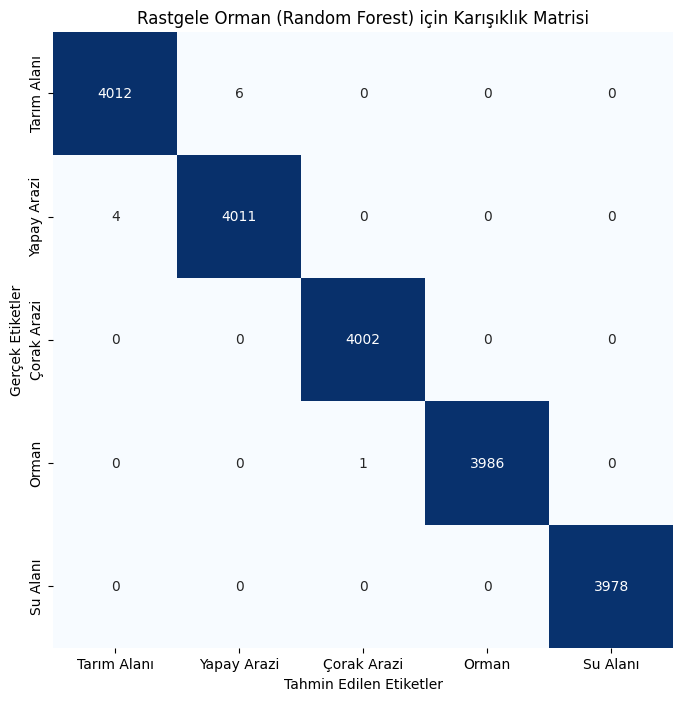

In [ ]:
plt.figure(figsize=(8, 8), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title(f'Rastgele Orman (Random Forest) için Karışıklık Matrisi')
plt.show()

Bu metrikler, modelin ne kadar doğru ve etkili çalıştığını anlamamıza yardımcı olur.

Özellik önem dereceleri, hangi özelliklerin modelin tahminlerinde daha etkili olduğunu gösterir.

RandomForestClassifier için Özelliklerin Önem Dereceleri:
   Özellik      Önem
10     DEM  0.208157
1      B12  0.101710
0      B11  0.091621
9      BSI  0.072264
2       B2  0.069497
17    NDWI  0.068422
7       B7  0.047593
12     GLI  0.039637
8       B8  0.038595
3       B3  0.037486
15    NDTI  0.036874
6       B6  0.036571
5       B5  0.035074
4       B4  0.028339
11     EVI  0.027360
18    SAVI  0.022670
16    NDVI  0.018472
14    NDBI  0.010996
13    LSWI  0.008664


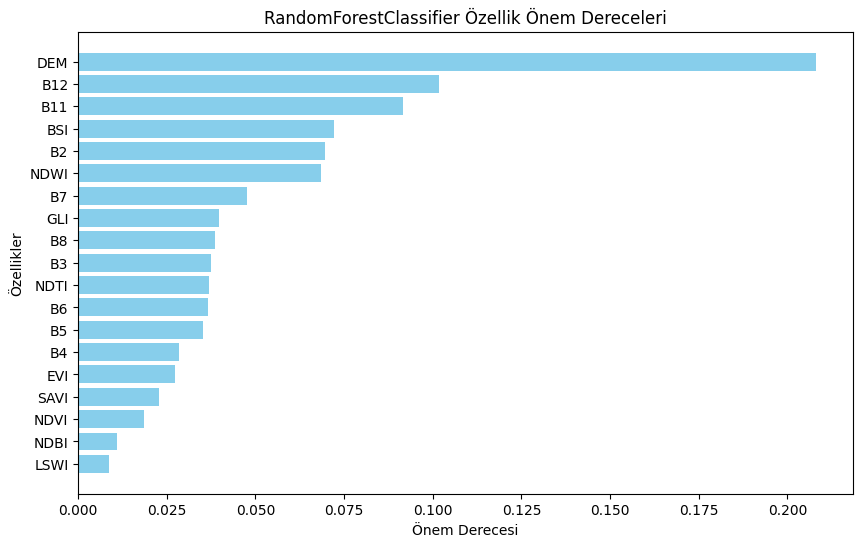

In [ ]:
if hasattr(clf, 'feature_importances_'):
    feature_importances = clf.feature_importances_
    feature_importance_df = pd.DataFrame({'Özellik': X_train.columns, 'Önem': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Önem', ascending=False)

    print(f"{clf.__class__.__name__} için Özelliklerin Önem Dereceleri:")
    print(feature_importance_df)

    feature_importance_df.to_csv(f"{clf.__class__.__name__}_ozellik_onemleri.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Özellik'], feature_importance_df['Önem'], color='skyblue')
    plt.xlabel('Önem Derecesi')
    plt.ylabel('Özellikler')
    plt.title(f"{clf.__class__.__name__} Özellik Önem Dereceleri")
    plt.gca().invert_yaxis()
    plt.show()

### **2.5. Modeli Kaydetme ve Lokal Cihaza İndirme**

Modeli kaydetmek, eğitim sürecini tekrarlamadan modelin tahminler yapmasını sağlar, böylece **zaman ve kaynak tasarrufu** elde edilir. Kaydedilen model başka sistemlerde de kullanılabilir, bu da projelerin **esnekliğini artırır ve dağıtımı kolaylaştırır**. Ayrıca, modelin kaydedilmesi, **veri yeniden toplanmadan tahmin yapmayı mümkün kılar ve ekipler arası paylaşımı hızlandırır**, projelerin daha verimli ilerlemesini sağlar.

In [ ]:
joblib.dump(clf, f"{clf.__class__.__name__}_model.pkl")

['RandomForestClassifier_model.pkl']

In [ ]:
from google.colab import files

files.download("/content/RandomForestClassifier_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **3. Açıklanabilir Yapay Zeka için SHAP'ı Oluşturma**

SHAP (SHapley Additive exPlanations), bir modelin tahminlerini açıklamak için kullanılan bir yöntemdir. Oyun teorisine dayanan bu yöntem, her bir özelliğin model tahminine katkısını hesaplar. Özelliklerin etkisi, her özelliğin tüm olası alt kümelerdeki katkılarına göre adil bir şekilde belirlenir. Bu sayede her özellik, modelin tahminine yaptığı katkı kadar "ödüllendirilir". SHAP, bu katkıları görselleştirerek, özelliklerin model tahminlerine nasıl etki ettiğini anlamamıza yardımcı olur. Özellikle sağlık, finans ve ceza adaleti gibi alanlarda bu tür açıklanabilirlik, güven oluşturmak için oldukça önemlidir.

1. **SHAP kütüphanesini içe aktarın:** `import shap`
   - Bu, makine öğrenimi modellerinin çıktılarını açıklamak için kullanılan SHAP kütüphanesini içe aktarır.

2. **JS görselleştirmesini başlatın:** `shap.initjs()`
   - Bu, Jupyter defterinde SHAP grafiklerinin JavaScript görselleştirmesini başlatır.


Önceden eğitilmiş modeli, `joblib` kütüphanesi aracılığıyla tekrardan eğitmeye gerek kalmadan
 yüklenebilir.

In [ ]:
model = joblib.load('/content/RandomForestClassifier_model.pkl')
# y_pred = model.predict(X_test)
shap_values = np.load('/content/RF_shap_values.npy')

In [ ]:
class_index_to_name = {
    0: 'Tarım Alanı',
    1: 'Yapay Alan',
    2: 'Çorak Arazi',
    3: 'Orman',
    4: 'Su Alanı'
}

In [ ]:
def f(X):
    return model.predict_proba(X)

`y_train`'den özet grafiği için sınıf başına 50 örnek seçilir.

In [ ]:
classes = np.unique(y_train)
samples_per_class = 50

selected_indices = []
for c in classes:
    indices = np.where(y_train == c)[0]
    selected_indices.extend(np.random.choice(indices, samples_per_class, replace=False))

X_train_subset = X_train.iloc[selected_indices]
y_train_subset = y_train.iloc[selected_indices]

In [ ]:
class_distribution = y_train_subset.map(class_index_to_name).value_counts()
print("y_train_subset içindeki sınıf dağılımı:")
print(class_distribution)

y_train_subset içindeki sınıf dağılımı:
Class_Encoded
Tarım Alanı    50
Yapay Alan     50
Çorak Arazi    50
Orman          50
Su Alanı       50
Name: count, dtype: int64


`y_test`'ten özet grafiği için sınıf başına 20 örnek seçilir.

In [ ]:
classes = np.unique(y_test)
samples_per_class = 20

selected_indices = []
for c in classes:

    indices = np.where(y_test == c)[0]
    selected_indices.extend(np.random.choice(indices, samples_per_class, replace=False))

X_test_subset = X_test.iloc[selected_indices]
y_test_subset = y_test.iloc[selected_indices]

In [ ]:
class_distribution = y_test_subset.map(class_index_to_name).value_counts()
print("y_test_subset içindeki sınıf dağılımı:")
print(class_distribution)

y_test_subset içindeki sınıf dağılımı:
Class_Encoded
Tarım Alanı    20
Yapay Alan     20
Çorak Arazi    20
Orman          20
Su Alanı       20
Name: count, dtype: int64


Alt küme verilerini kullanarak özet grafiği oluşturulur.

In [ ]:
columns = X_test.columns

Bu fonksiyon, eğitilmiş bir modeli (`model`), giriş verisini (`X`), görselleştirme verisini (`X_display`) ve model adını (`model_name`) alır. SHAP açıklayıcı oluşturur, SHAP değerlerini hesaplar ve özelliklerin model tahminlerine etkisini gösteren bir özet grafik çizer.

Bu döngü, her model ve en iyi parametreleriyle modeli eğitir, ardından SHAP özet grafiğini çizmek için `visualize_shap` fonksiyonunu çağırır.

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_subset)

In [ ]:
np.save('/content/RF_shap_values.npy', shap_values)

In [ ]:
print(f"X_test_subset.shape: {X_test_subset.shape} - Bu, {X_test_subset.shape[0]} örnek ve {X_test_subset.shape[1]} özelliği içeren test verinizin alt kümesidir. Her satır bir örneği, her sütun ise bir özelliği temsil eder.")
print(f"shap_values[0].shape: {shap_values[0].shape} - Bu, ilk sınıf için SHAP değerleridir. {shap_values[0].shape[0]} özellik ve {shap_values[0].shape[1]} örnek içerir. Her satır bir özelliği, her sütun bir örneği temsil eder.")
print(f"shap_values.shape: {shap_values.shape} - Bu, genel SHAP değerlerinizin şeklidir. {shap_values.shape[0]} sınıf, {shap_values.shape[1]} özellik ve her sınıf başına {shap_values.shape[2]} örnek içerir. İlk boyut sınıfları, ikinci boyut özellikleri ve üçüncü boyut örnekleri temsil eder.")
print(f"X_test[:5].shape: {X_test[:5].shape} - Bu, test verinizin ilk 5 örneği olup {X_test[:5].shape[1]} özellik içerir. Her satır bir örneği, her sütun ise bir özelliği temsil eder.")
print(f"shap_values[:, :, 0].shape: {shap_values[:, :, 0].shape} - Bu, tüm sınıflar için ilk örnek için SHAP değerleridir. İlk boyut sınıfları, ikinci boyut özellikleri ve üçüncü boyut (bu durumda 0) örnek indeksini temsil eder.")

X_test_subset.shape: (100, 19) - Bu, 100 örnek ve 19 özelliği içeren test verinizin alt kümesidir. Her satır bir örneği, her sütun ise bir özelliği temsil eder.
shap_values[0].shape: (19, 5) - Bu, ilk sınıf için SHAP değerleridir. 19 özellik ve 5 örnek içerir. Her satır bir özelliği, her sütun bir örneği temsil eder.
shap_values.shape: (100, 19, 5) - Bu, genel SHAP değerlerinizin şeklidir. 100 sınıf, 19 özellik ve her sınıf başına 5 örnek içerir. İlk boyut sınıfları, ikinci boyut özellikleri ve üçüncü boyut örnekleri temsil eder.
X_test[:5].shape: (5, 19) - Bu, test verinizin ilk 5 örneği olup 19 özellik içerir. Her satır bir örneği, her sütun ise bir özelliği temsil eder.
shap_values[:, :, 0].shape: (100, 19) - Bu, tüm sınıflar için ilk örnek için SHAP değerleridir. İlk boyut sınıfları, ikinci boyut özellikleri ve üçüncü boyut (bu durumda 0) örnek indeksini temsil eder.


### **3.1. Bağımlılık Grafiği (Dependence Plot)**

Her özellik ve sınıf için ortalama mutlak SHAP değerleri, modelin tahminlerine her bir özelliğin katkısını ölçen bir analiz yöntemidir. SHAP değerleri, her bir özelliğin modelin çıktısındaki etkisini belirler. Ortalama mutlak SHAP değeri, her bir özelliğin tüm sınıflar için sağladığı katkıyı özetler ve bu sayede özelliklerin modeldeki göreceli önemini anlamamıza yardımcı olur. Bu analiz, modelin karar verme süreçlerini daha şeffaf hale getirir ve hangi özelliklerin sınıflandırmada daha fazla etkili olduğunu gösterir.

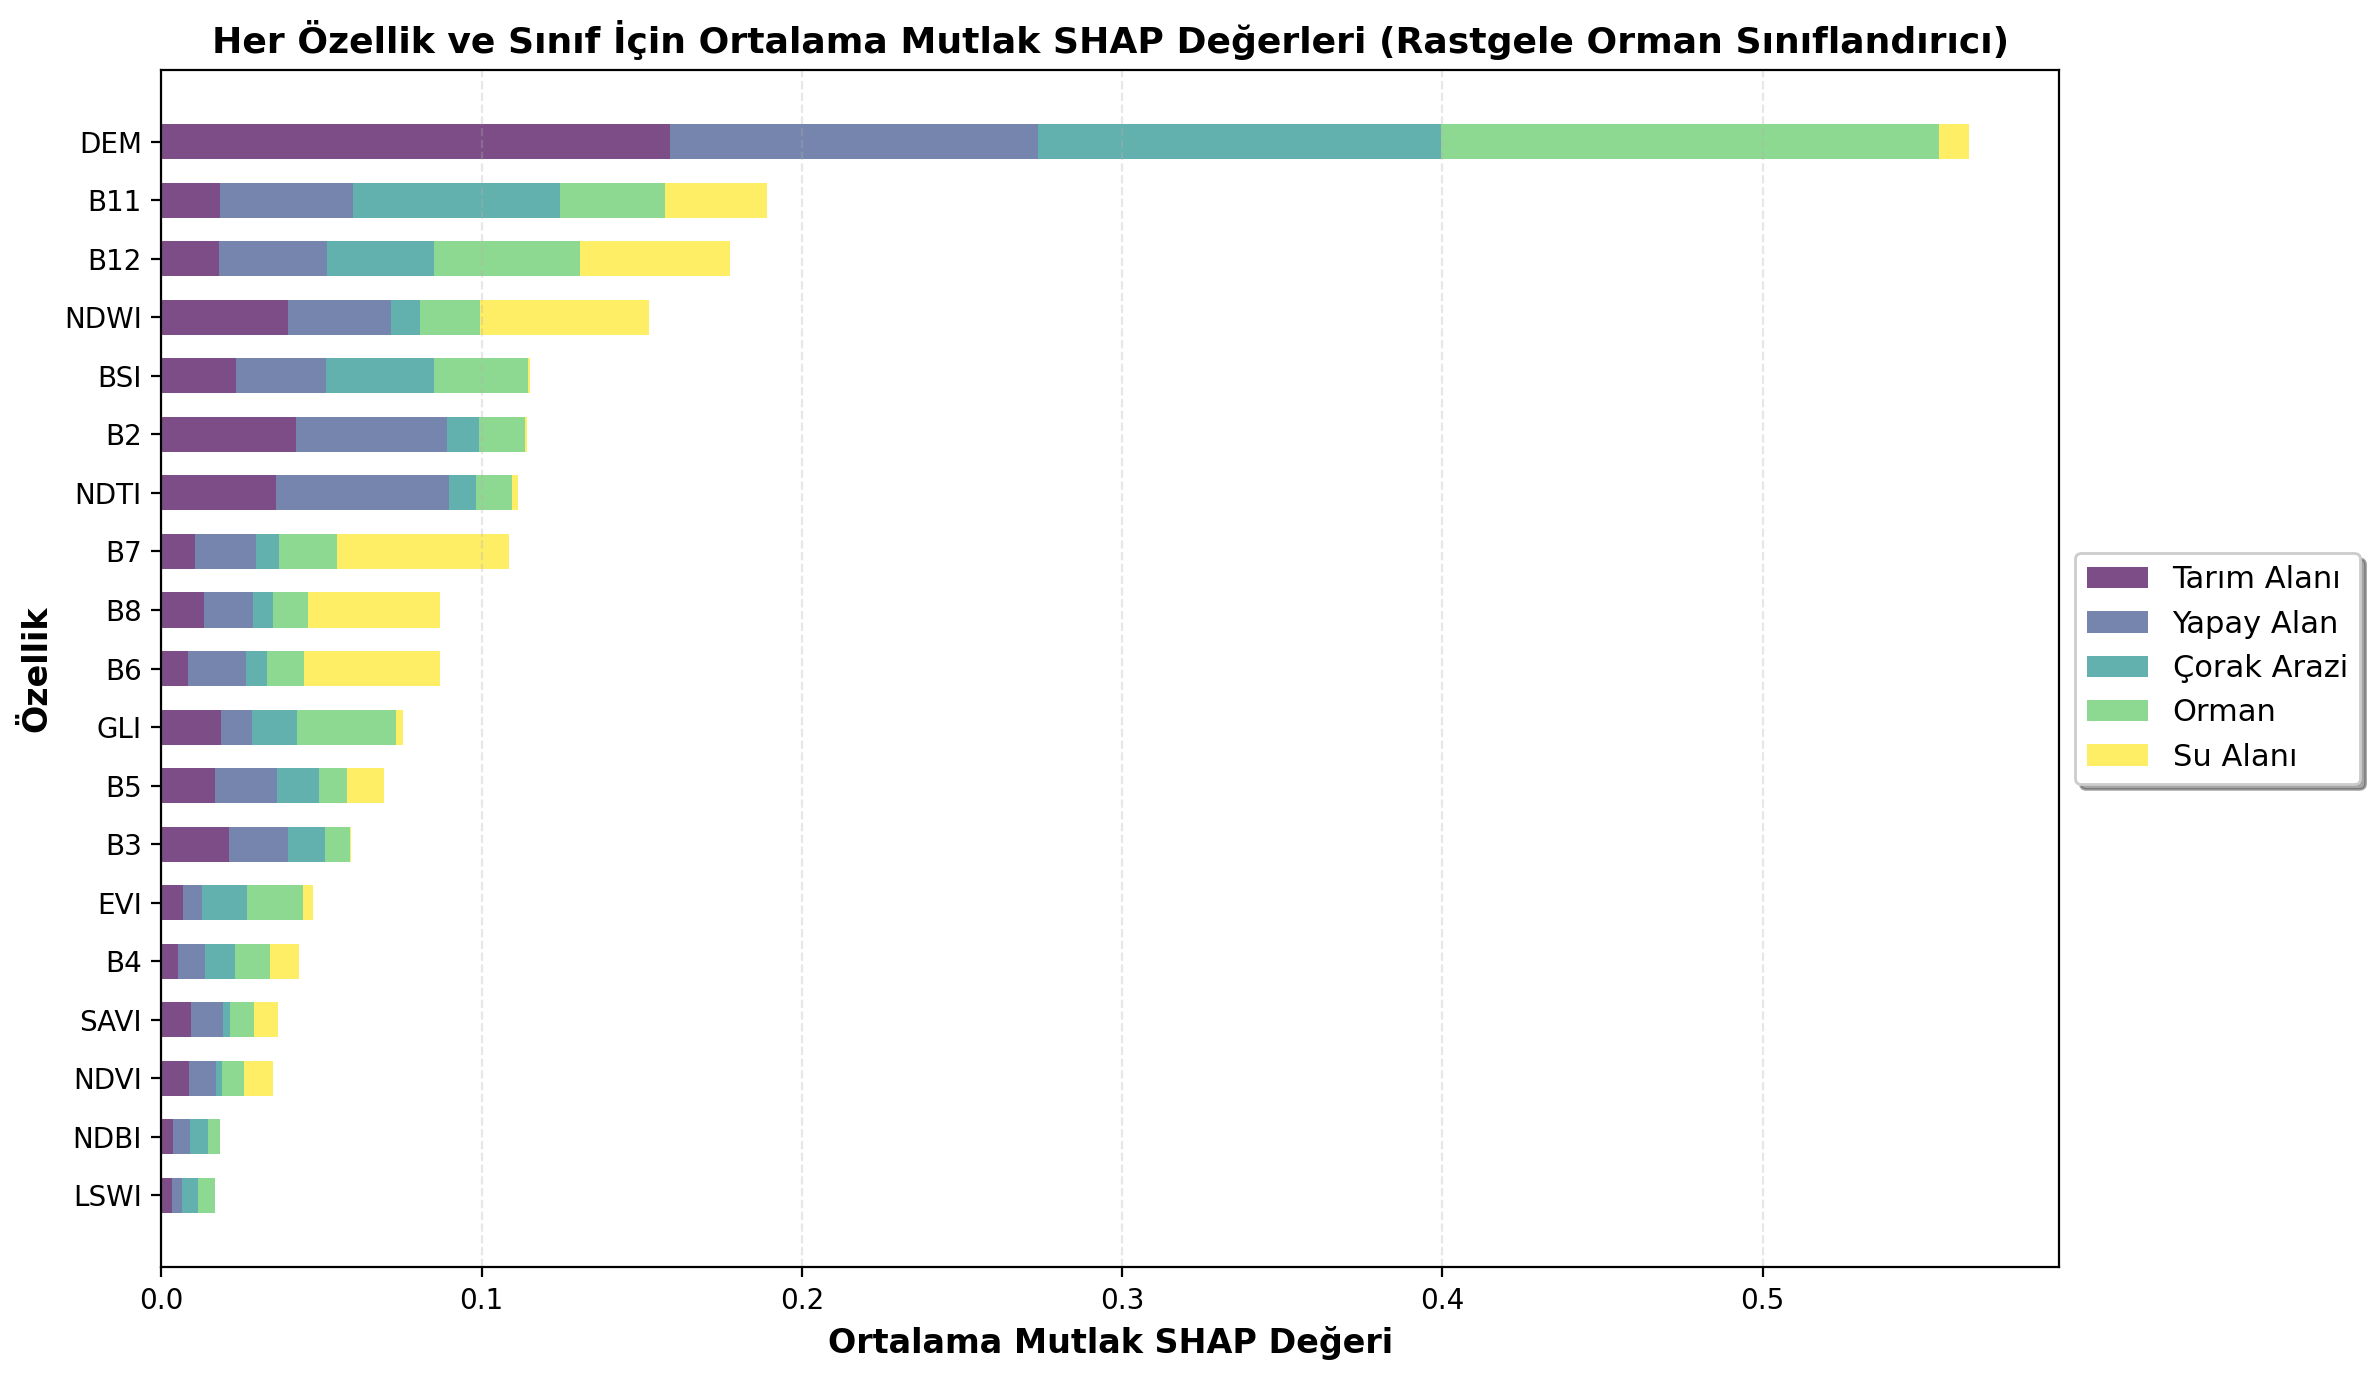

In [ ]:
# @markdown Grafiği çizdir.

shap_values_mean = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(np.mean(shap_values_mean, axis=1))

colors = plt.cm.viridis(np.linspace(0, 1, shap_values_mean.shape[1]))

plt.figure(figsize=(12, 7), dpi=200)
bottom = np.zeros(len(columns))

for class_idx in range(shap_values_mean.shape[1]):
    plt.barh(np.arange(len(columns)), shap_values_mean[sorted_idx, class_idx],
             left=bottom, height=0.6, color=colors[class_idx], alpha=0.7, label=class_index_to_name[class_idx])
    bottom += shap_values_mean[sorted_idx, class_idx]

plt.yticks(np.arange(len(columns)), np.array(columns)[sorted_idx], fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Ortalama Mutlak SHAP Değeri', fontsize=12, fontweight='bold')
plt.ylabel('Özellik', fontsize=12, fontweight='bold')
plt.title("Her Özellik ve Sınıf İçin Ortalama Mutlak SHAP Değerleri (Rastgele Orman Sınıflandırıcı)", fontsize=13, fontweight='bold')
plt.legend(fontsize=11, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig('/content/Ortalama Mutlak SHAP Değerleri.png', bbox_inches='tight')
plt.show()

Bağımlılık grafiği, özellikle etkileşimleri gözlemlememize yardımcı olur; bir özelliğin etkisi, diğer özelliklerle nasıl değişiyorsa, bu etkileşimlerin nasıl şekillendiğini gösterir. Bu analiz, modelin daha doğru yorumlanmasına olanak tanır ve özellikler arasındaki ilişkilerin modelin tahminlerine nasıl yansıdığını açıkça ortaya koyar. Tabloda, sırasıyla her sınıf için en çok etkilenen 3 değişkeni alınır.

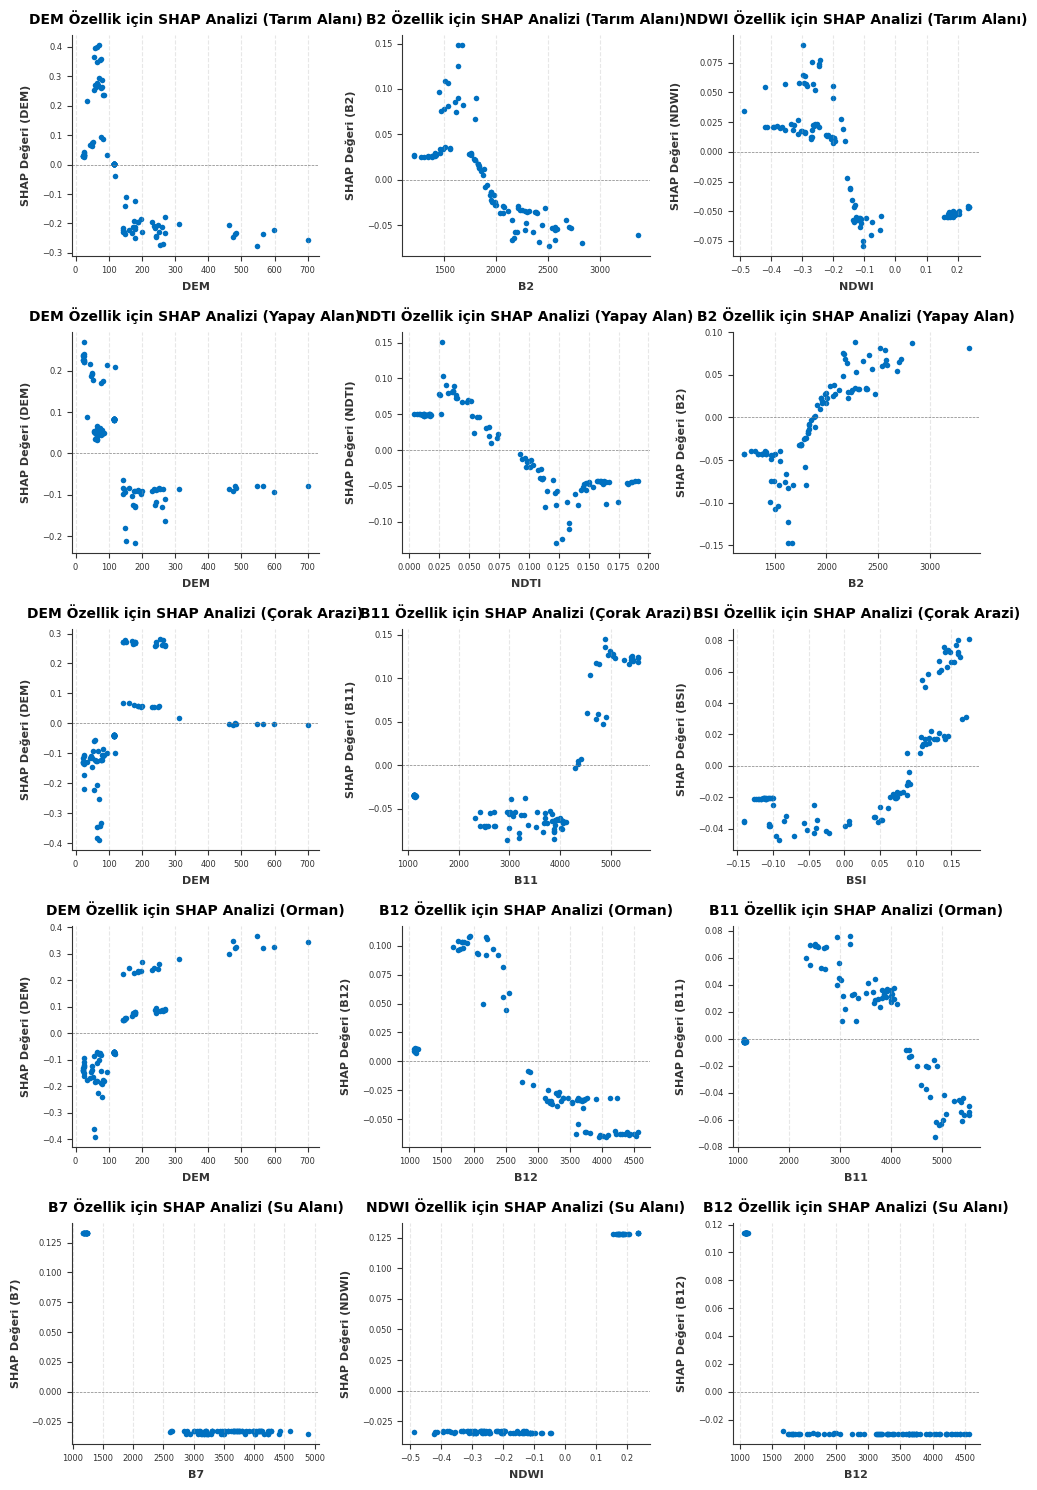

In [ ]:
# @markdown Grafiği çizdir.

shap_values_mean = np.mean(np.abs(shap_values), axis=0)

fig, axs = plt.subplots(5, 3, figsize=(10, 15), dpi=100)

axs_flat = axs.flatten()

for class_index in range(shap_values_mean.shape[1]):

    sorted_features = np.argsort(shap_values_mean[:, class_index])[::-1]
    top_features = sorted_features[:3]  # İlk 3 özellik

    for i, feature_index in enumerate(top_features):
        title = f"{columns[feature_index]} Özellik için SHAP Analizi ({class_index_to_name[class_index]})"
        shap.dependence_plot(feature_index, shap_values[:, :, class_index], X_test_subset, ax=axs_flat[class_index*3 + i], show=False, interaction_index=None, color="#0070c0")
        axs_flat[class_index*3 + i].axhline(y=0.00, color='gray', linestyle='--', linewidth=0.5)  # y=0.00 için gri '--' çizgisi ekle
        axs_flat[class_index*3 + i].set_title(title, fontsize=10, fontweight='bold', pad=8)
        axs_flat[class_index*3 + i].set_xlabel(f"{columns[feature_index]}", fontsize=8, fontweight='bold', labelpad=5)
        axs_flat[class_index*3 + i].set_ylabel(f"SHAP Değeri ({columns[feature_index]})", fontsize=8, fontweight='bold', labelpad=8)
        axs_flat[class_index*3 + i].tick_params(axis='both', which='major', labelsize=6)
        axs_flat[class_index*3 + i].grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('dependence_plots_grid.png', bbox_inches='tight', dpi=200)
plt.show()

### **3.2. Özet Grafiği (Summary Plot)**

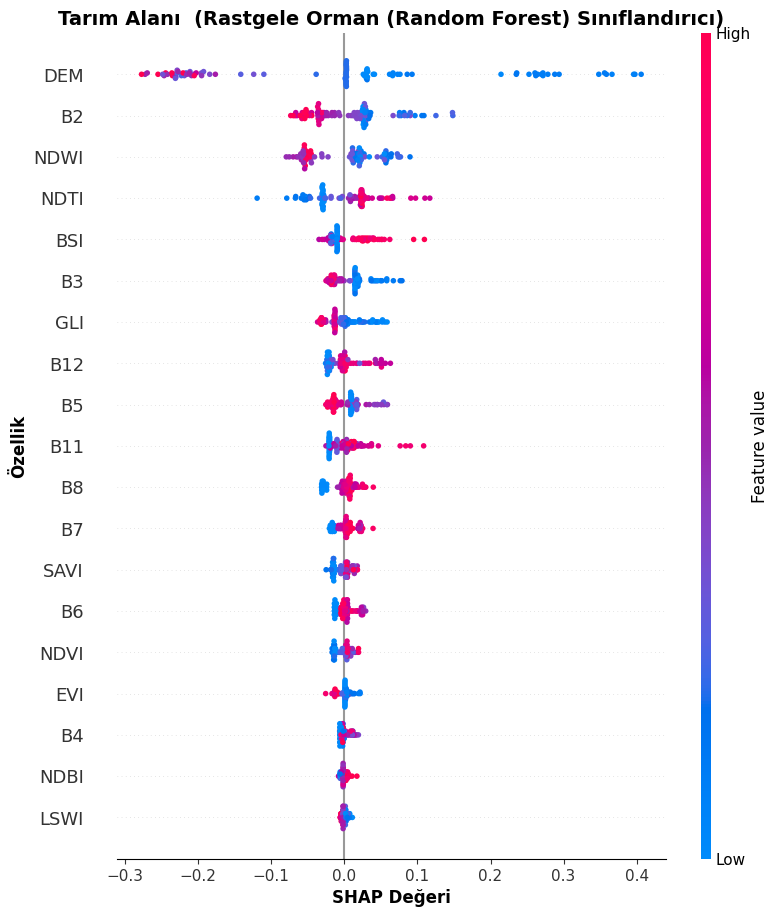

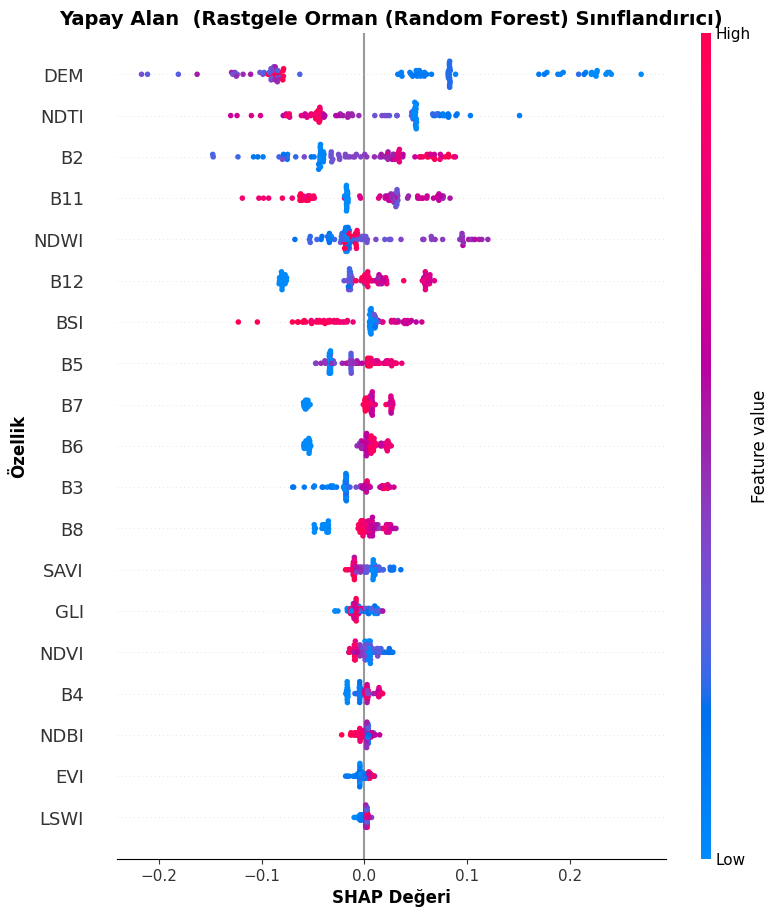

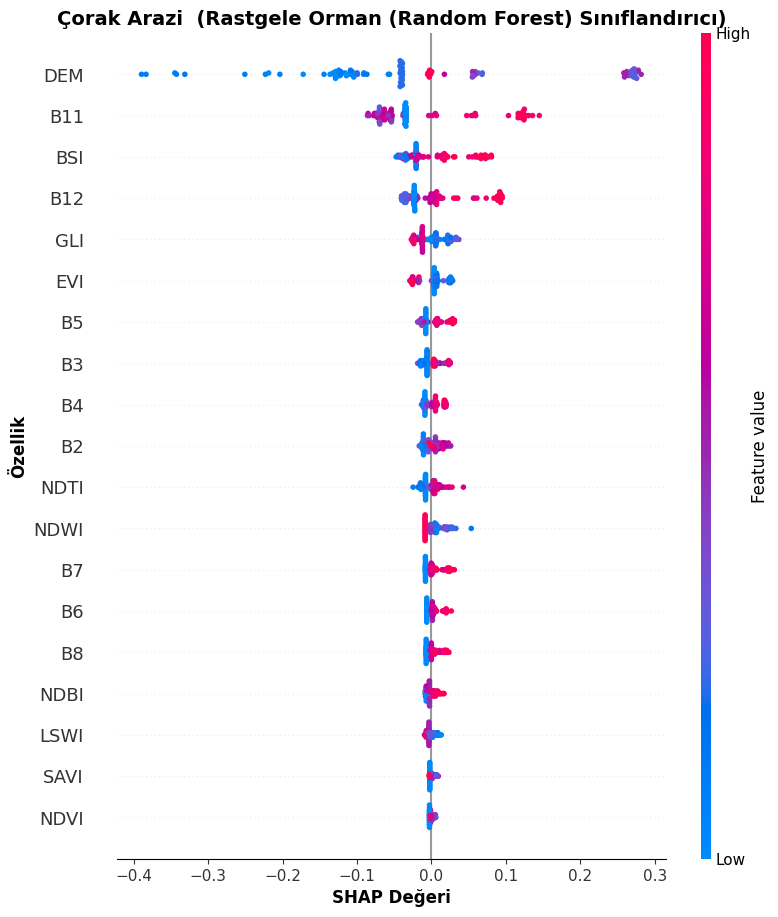

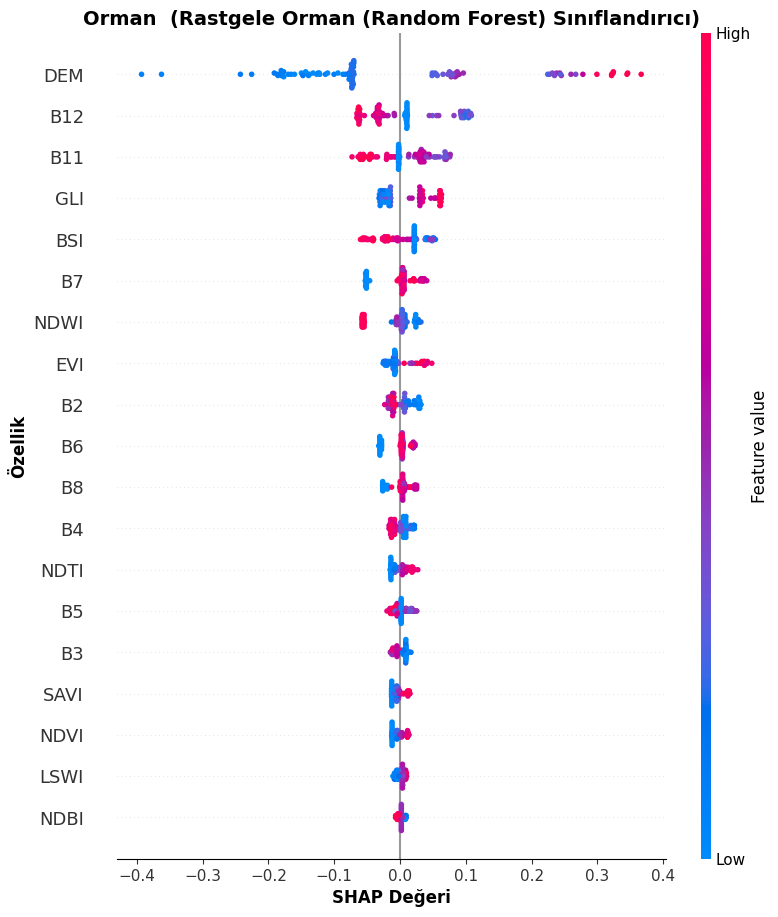

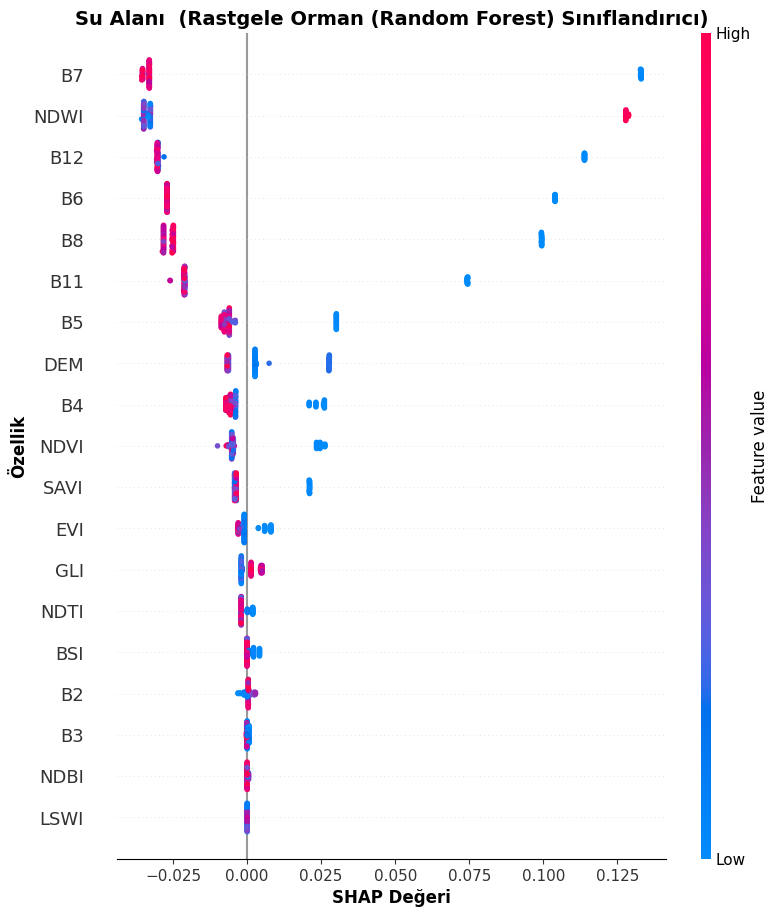

In [ ]:
# @markdown Grafiği çizdir.

for i in range(5):
    plt.figure(figsize=(8, 6), dpi=100)
    shap.summary_plot(shap_values[:, :, i], features=X_test_subset, plot_type="dot", feature_names=columns, max_display=100, show=False)
    plt.title(f"{class_index_to_name[i]}  (Rastgele Orman (Random Forest) Sınıflandırıcı)", fontsize=14, fontweight='bold')
    plt.xlabel("SHAP Değeri", fontsize=12, fontweight='bold')
    plt.ylabel("Özellik", fontsize=12, fontweight='bold')
    plt.savefig(f'shap_values_plot_{class_index_to_name[i]}.png', bbox_inches='tight')
    plt.show()

### **3.3. Etkileşim Grafiği (Force Plot)**

In [ ]:
shap.initjs()

idx = 0
class_index = 0

shap_values_idx = shap_values[idx, :, class_index]
shap.force_plot(explainer.expected_value[class_index], shap_values_idx, X_test_subset.iloc[idx, :])

In [ ]:
class_name = class_index_to_name[class_index]
print(f"İndeks {idx}: {class_name}")

İndeks 0: Tarım Alanı


### **3.4. SHAP Sahne Görselleştirmesi**

In [ ]:
shap_agri = np.load('/content/agriculture_RF_shap_values.npy')
shap_arti = np.load('/content/artificial_RF_shap_values.npy')
shap_barr = np.load('/content/barren_RF_shap_values.npy')
shap_fore = np.load('/content/forest_RF_shap_values.npy')
shap_wate = np.load('/content/water_RF_shap_values.npy')

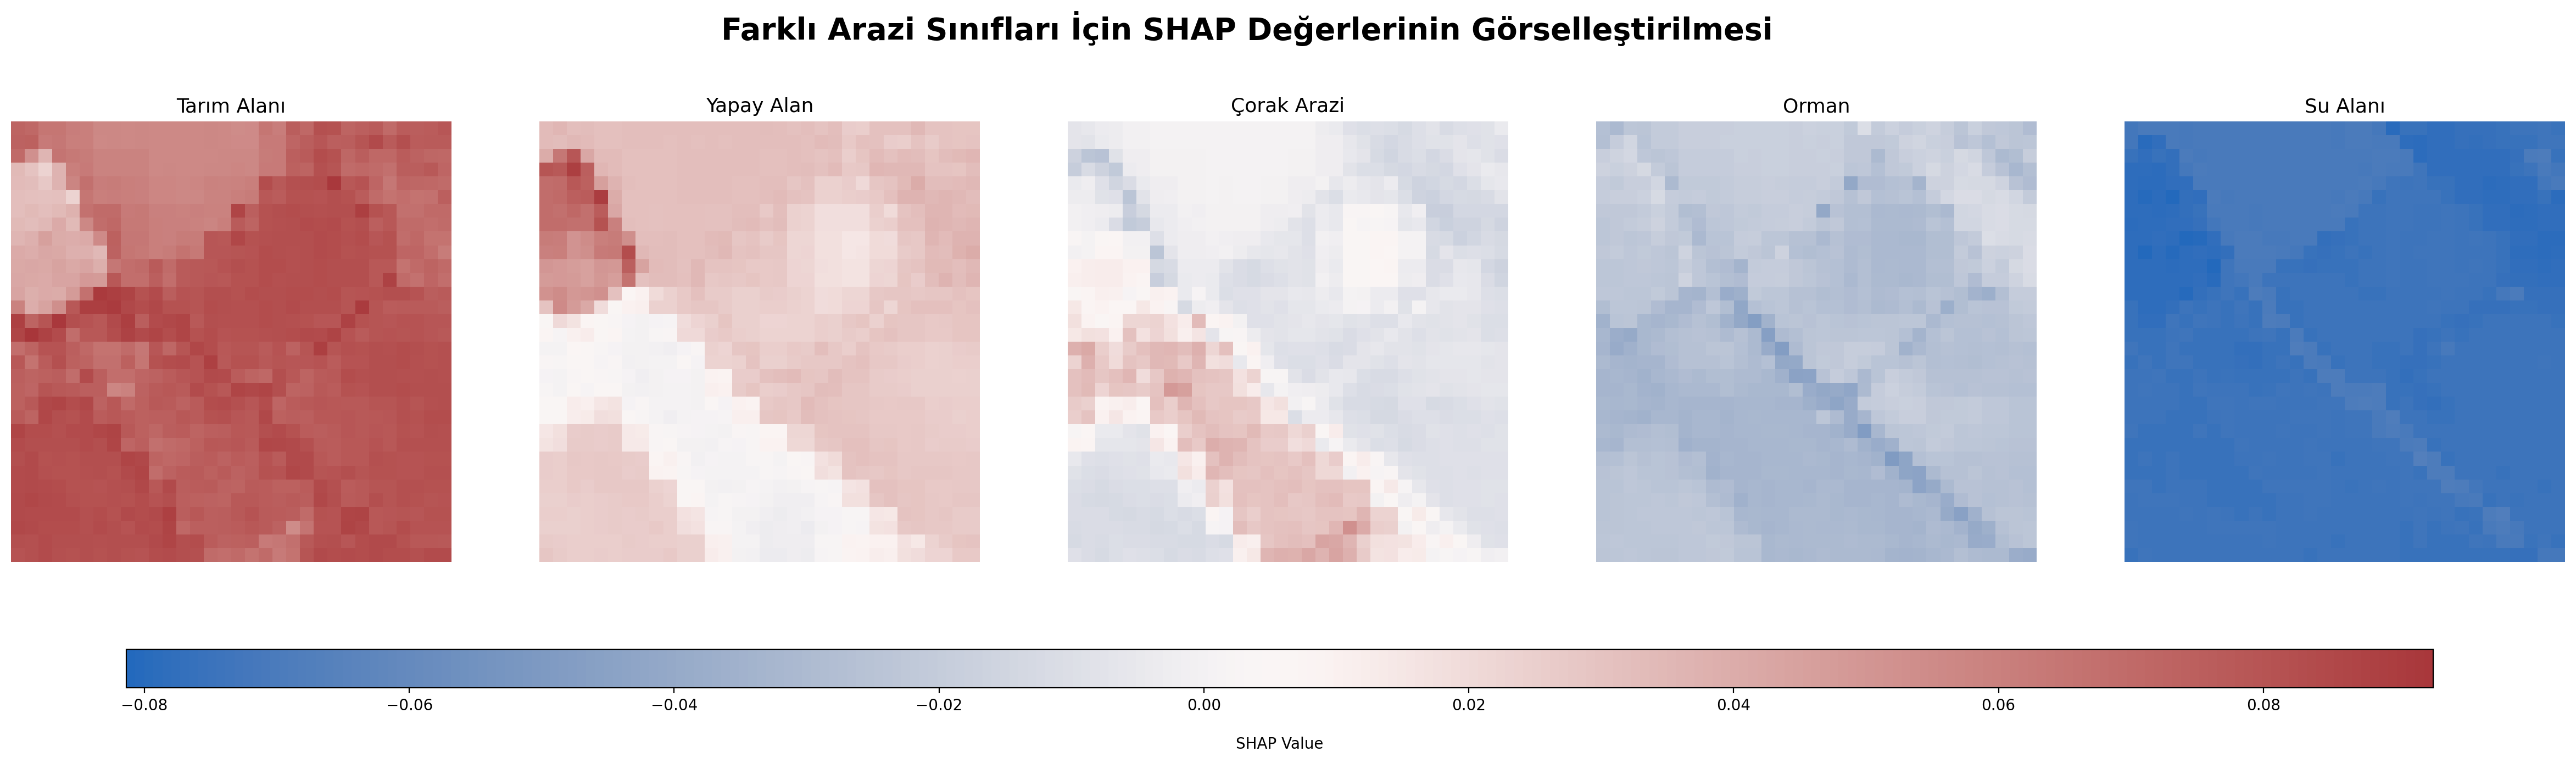

In [ ]:
reshaped_values = shap_agri.reshape(2500, -1)[:, :5]  # 'shap_agri' değişkeni değiştirilerek diğer sınıfların görselleştirmesi yapılabilir.
reshaped_values = reshaped_values.reshape(50, 50, 5)

reshaped_values = reshaped_values[:32, :32, :]

global_min = np.min(reshaped_values)
global_max = np.max(reshaped_values)

fig, axs = plt.subplots(1, 5, figsize=(30, 7), dpi=200)

for i in range(5):
    im = axs[i].imshow(reshaped_values[:, :, i], cmap='vlag', vmin=global_min, vmax=global_max)
    axs[i].set_title(class_index_to_name[i], fontsize=13)
    axs[i].axis('off')

cbar_ax = fig.add_axes([0.16, 0.1, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('SHAP Value', labelpad=15)

plt.suptitle('Farklı Arazi Sınıfları İçin SHAP Değerlerinin Görselleştirilmesi', fontsize=20, fontweight='bold')
plt.subplots_adjust(bottom=0.2, top=0.90)
plt.savefig('/content/SHAP_visual.png')
plt.show()

## **4. Verileri Lokal Cihaza İndirme**

In [ ]:
from google.colab import files

files.download("/content/Ortalama Mutlak SHAP Değerleri.png")
files.download("/content/shap_values_plot_Orman.png")
files.download("/content/shap_values_plot_Su Alanı.png")
files.download("/content/shap_values_plot_Tarım Alanı.png")
files.download("/content/shap_values_plot_Yapay Alan.png")
files.download("/content/shap_values_plot_Çorak Arazi.png")
files.download("/content/dependence_plots_grid.png")
files.download("/content/SHAP_visual.png")

files.download("/content/RF_shap_values.npy")

**Akılınıza takılan bir soru varsa, lütfen bizimle paylaşın. Yardımcı olmaktan memnuniyet duyarız:**

<br>

- **Doğu İlmak** - doguilmak@gmail.com

- **Doç. Dr. Muzaffer Can IBAN** - caniban@mersin.edu.tr